In [96]:
from matplotlib import rcParams 
from matplotlib.pyplot import subplots 
from matplotlib.pyplot import show, close  
from pandas import read_csv, DataFrame, Series
from pandas import concat
from pandas import CategoricalIndex, MultiIndex
from IPython.display import display, Markdown 

rcParams.update({
    "font.family": "STIXGeneral",
    "mathtext.fontset": "stix",
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "axes.linewidth": 1.1,
})

SEEDS = [1, 11, 42] 
LANGUAGE = 'es' 
WINDOW = 20 
FIGURES  = './assets'  
SIZES = ['S', 'M', 'L']
NAMES = ['SwiGLUViT', 'CanonicalViT', 'GrandCanonicalViT']

def getpath(model: str, size: str, seed: int) -> str: 
    configuration = {
        'S': dict(p=0.3, hdim=128, dim=64),
        'M': dict(p=0.3, hdim=256, dim=64),
        'L': dict(p=0.4, hdim=256, dim=128),
    }

    if size not in configuration:
        raise ValueError(f"Size inválido: {size}")
 
    return (
        f"./logs/{model}-s{seed}-p={configuration[size]['p']}-hdim={configuration[size]['hdim']}"
        f"-imgz=32x32-dim={configuration[size]['dim']}"
        f"-number_of_channels=3-ncls=10"
        f"-nhead=4-nlayer=4-pz=4x4.csv"
    )


def pm(mean: Series, std: Series, decimals: int=4):
    return mean.round(decimals).astype(str) + ' ± ' + std.round(decimals).astype(str)


In [97]:
from pandas import CategoricalDtype

TEXT = {
    'es': {
        'size' : 'Tamaño',
        'mean' : 'Promedio',
        'max'  : 'Máxima',
        'epoch': 'Época',
        'title': 'Exactitud',
    }, 
}

for name in NAMES:
    text = TEXT[LANGUAGE]
    rows = []

    for size in ['S', 'M', 'L']:
        for seed in SEEDS:
            dataframe = read_csv(getpath(name, size, seed))
            dataframe = dataframe.loc[dataframe['phase'] == 'evaluation'].tail(WINDOW)

            rows.append({
                text['size']: size,
                'seed': seed,
                text['mean']: dataframe['accuracy'].mean(),
                text['max']: dataframe['accuracy'].max(),
                text['epoch']: dataframe.loc[dataframe['accuracy'].idxmax(), 'epoch'],
            })

    dataframe = DataFrame(rows)
    dataframe[text['size']] = dataframe[text['size']].astype(
        CategoricalDtype(categories=['S', 'M', 'L'], ordered=True)
    )

    dataframe = dataframe.set_index([text['size'], 'seed']).sort_index()
    dataframe.index.names = [text['size'], 'seed']

    display(Markdown(f"### {name} {text['title']} (valores por semilla)"))
    display(dataframe)


### SwiGLUViT Exactitud (valores por semilla)

Promedio  Máxima  Época
Tamaño seed                         
S      1     0.750700  0.7530    297
       11    0.747810  0.7512    294
       42    0.745800  0.7484    291
M      1     0.765350  0.7686    294
       11    0.772055  0.7749    293
       42    0.769815  0.7726    288
L      1     0.766900  0.7702    292
       11    0.755740  0.7603    297
       42    0.757525  0.7629    282

### CanonicalViT Exactitud (valores por semilla)

Promedio  Máxima  Época
Tamaño seed                         
S      1     0.757750  0.7601    280
       11    0.759685  0.7620    281
       42    0.764140  0.7669    298
M      1     0.772845  0.7747    286
       11    0.770720  0.7734    284
       42    0.771635  0.7735    297
L      1     0.782710  0.7850    297
       11    0.778300  0.7802    288
       42    0.785915  0.7885    289

### GrandCanonicalViT Exactitud (valores por semilla)

Promedio  Máxima  Época
Tamaño seed                         
S      1      0.77450  0.7776    291
       11     0.76865  0.7715    297
       42     0.77485  0.7768    289
M      1      0.78680  0.7892    298
       11     0.78621  0.7882    282
       42     0.78596  0.7879    292
L      1      0.79413  0.7959    297
       11     0.79503  0.7969    284
       42     0.79888  0.8009    297

In [98]:
TEXT = {
    'es': {
        'size' : 'Tamaño',
        'mean' : 'Promedio',
        'max'  : 'Máxima',
        'epoch': 'Época',
        'title': 'Exactitud',
    }, 
}

dataframes = list[DataFrame]()
for name in NAMES:
    text = TEXT[LANGUAGE]
    rows = []

    for size in SIZES:
        for seed in SEEDS:
            dataframe = read_csv(getpath(name, size, seed))
            dataframe = dataframe.loc[dataframe['phase'] == 'evaluation'].tail(WINDOW)

            rows.append({
                text['size']: size,
                'seed': seed,
                'mean_acc': dataframe['accuracy'].mean(),
                'max_acc': dataframe['accuracy'].max(),
                'epoch_max': dataframe.loc[dataframe['accuracy'].idxmax(), 'epoch']
            })

    dataframe = DataFrame(rows)

    results = (
        dataframe
        .groupby(text['size'])
        .agg(
            mean_accuracy=('mean_acc', 'mean'),
            std_accuracy =('mean_acc', 'std'),
            mean_max     =('max_acc', 'mean'),
            std_max      =('max_acc', 'std'),
            mean_epoch   =('epoch_max', 'mean'),
            std_epoch    =('epoch_max', 'std'),
        )
    )
 
    dataframe = DataFrame({
        text['mean'] : pm(results['mean_accuracy'], results['std_accuracy']),
        text['max']  : pm(results['mean_max'],      results['std_max']),
        text['epoch']: pm(results['mean_epoch'],    results['std_epoch']),
    }, index=results.index)
 
    dataframe['Nombre'] = name
    dataframe = dataframe.set_index('Nombre', append=True)
    dataframe = dataframe.reorder_levels(['Nombre', text['size']])

    dataframes.append(dataframe)
 
dataframe = concat(dataframes)


names = CategoricalIndex(
    dataframe.index.get_level_values('Nombre'),
    categories=NAMES,
    ordered=True
)

sizes = CategoricalIndex(
    dataframe.index.get_level_values(text['size']),
    categories=SIZES,
    ordered=True
)

dataframe.index = MultiIndex.from_arrays(
    [names, sizes],
    names=['Nombre', text['size']]
)

dataframe = dataframe.sort_index() 
display(dataframe)


Promedio           Máxima              Época
Nombre            Tamaño                                                     
SwiGLUViT         S       0.7481 ± 0.0025  0.7509 ± 0.0023        294.0 ± 3.0
                  M       0.7691 ± 0.0034   0.772 ± 0.0032  291.6667 ± 3.2146
                  L        0.7601 ± 0.006  0.7645 ± 0.0051  290.3333 ± 7.6376
CanonicalViT      S       0.7605 ± 0.0033   0.763 ± 0.0035  286.3333 ± 10.116
                  M       0.7717 ± 0.0011  0.7739 ± 0.0007        289.0 ± 7.0
                  L       0.7823 ± 0.0038  0.7846 ± 0.0042  291.3333 ± 4.9329
GrandCanonicalViT S       0.7727 ± 0.0035  0.7753 ± 0.0033  292.3333 ± 4.1633
                  M       0.7863 ± 0.0004  0.7884 ± 0.0007  290.6667 ± 8.0829
                  L        0.796 ± 0.0025  0.7979 ± 0.0026  292.6667 ± 7.5056

In [99]:
TEXT = {
    'es': {
        'size' : 'Tamaño',
        'mean' : 'Promedio',
        'max'  : 'Máxima',
        'epoch': 'Época',
        'title': 'Exactitud',
    }, 
}

dataframes = list[DataFrame]()
SIZES = ['S', 'M', 'L']
NAMES = ['SwiGLUViT', 'CanonicalViT', 'GrandCanonicalViT']

for name in NAMES:
    text = TEXT[LANGUAGE]
    rows = []

    for size in SIZES:
        for seed in SEEDS:
            dataframe = read_csv(getpath(name, size, seed))
            dataframe = dataframe.loc[dataframe['phase'] == 'evaluation'].tail(WINDOW)

            rows.append({
                text['size']: size,
                'seed': seed,
                'mean_acc': dataframe['accuracy'].mean(),
                'max_acc': dataframe['accuracy'].max(),
                'epoch_max': dataframe.loc[dataframe['accuracy'].idxmax(), 'epoch']
            })

    dataframe = DataFrame(rows)

    results = (
        dataframe
        .groupby(text['size'])
        .agg(
            mean_accuracy=('mean_acc', 'mean'),
            std_accuracy =('mean_acc', 'std'),
            mean_max     =('max_acc', 'mean'),
            std_max      =('max_acc', 'std'),
            mean_epoch   =('epoch_max', 'mean'),
            std_epoch    =('epoch_max', 'std'),
        )
    )

    dataframe = DataFrame({
        text['mean'] : pm(results['mean_accuracy'], results['std_accuracy']),
        text['max']  : pm(results['mean_max'],      results['std_max']),
        text['epoch']: pm(results['mean_epoch'],    results['std_epoch']),
    }, index=results.index)
 
    dataframe['Nombre'] = name
    dataframe = dataframe.set_index('Nombre', append=True) 
    dataframe = dataframe.reorder_levels([text['size'], 'Nombre']) 
    dataframes.append(dataframe)
 
order = CategoricalIndex(
    dataframe.index.get_level_values('Nombre'),
    categories=NAMES,
    ordered=True
)

dataframe = concat(dataframes) 

sizes = CategoricalIndex(
    dataframe.index.get_level_values('Tamaño'),
    categories=SIZES,
    ordered=True
)

names = CategoricalIndex(
    dataframe.index.get_level_values('Nombre'),
    categories=NAMES,
    ordered=True
)
 
dataframe.index = MultiIndex.from_arrays(
    [sizes, names],
    names=['Tamaño', 'Nombre']
)
 
dataframe = dataframe.sort_index() 
display(dataframe)


Promedio           Máxima              Época
Tamaño Nombre                                                                
S      SwiGLUViT          0.7481 ± 0.0025  0.7509 ± 0.0023        294.0 ± 3.0
       CanonicalViT       0.7605 ± 0.0033   0.763 ± 0.0035  286.3333 ± 10.116
       GrandCanonicalViT  0.7727 ± 0.0035  0.7753 ± 0.0033  292.3333 ± 4.1633
M      SwiGLUViT          0.7691 ± 0.0034   0.772 ± 0.0032  291.6667 ± 3.2146
       CanonicalViT       0.7717 ± 0.0011  0.7739 ± 0.0007        289.0 ± 7.0
       GrandCanonicalViT  0.7863 ± 0.0004  0.7884 ± 0.0007  290.6667 ± 8.0829
L      SwiGLUViT           0.7601 ± 0.006  0.7645 ± 0.0051  290.3333 ± 7.6376
       CanonicalViT       0.7823 ± 0.0038  0.7846 ± 0.0042  291.3333 ± 4.9329
       GrandCanonicalViT   0.796 ± 0.0025  0.7979 ± 0.0026  292.6667 ± 7.5056

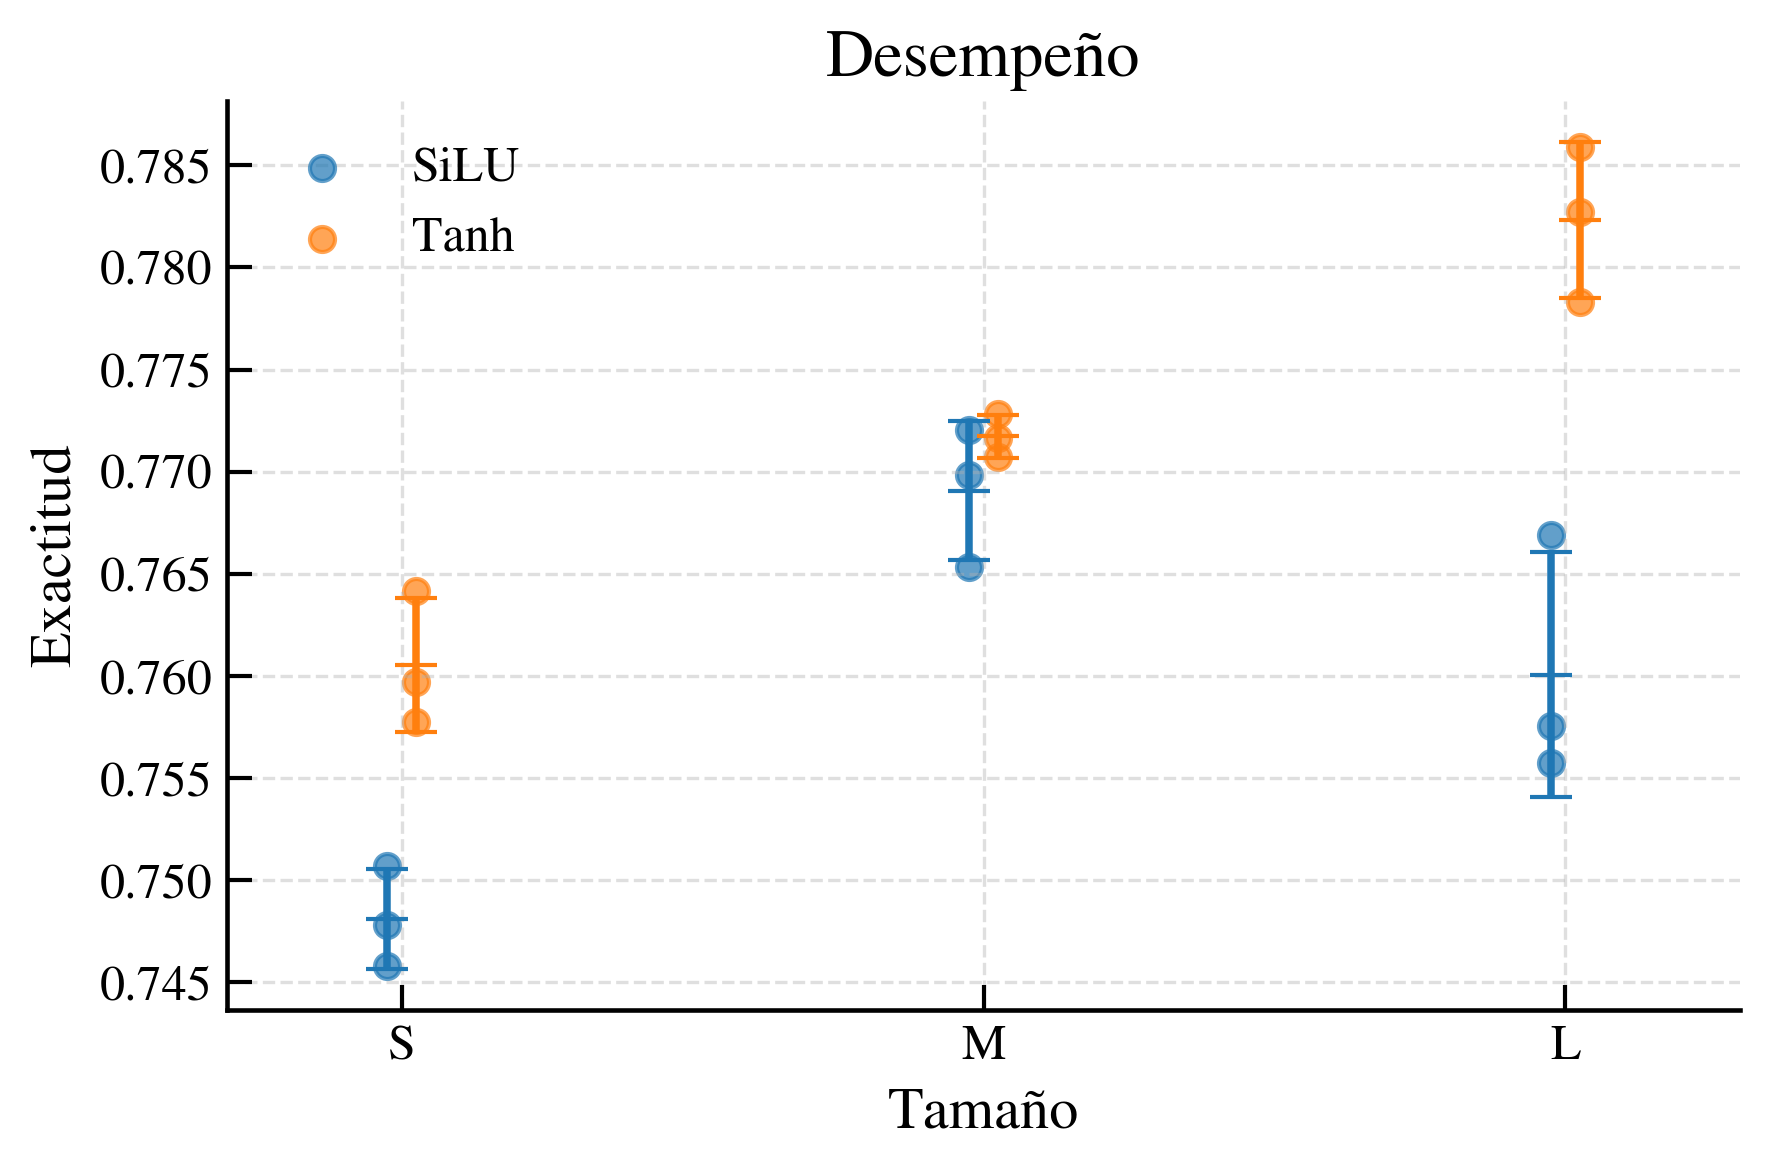

In [100]:
TEXT = {
    'es' : { 
        "xlabel": "Tamaño",
        "ylabel": "Exactitud", 
        'title' : "Desempeño",
        'size'  : 'Tamaño',
        'seed'  : 'Semilla',
        'name'  : 'Nombre',
        'mean'  : 'Promedio'
    }
}

STYLE = {
    "SwiGLUViT": {
        "label": "SiLU",
        "color": "C0",
        "offset": -0.025,
    },
    "CanonicalViT": {
        "label": "Tanh",
        "color": "C1",
        "offset": 0.025,
    },
}
 
text = TEXT[LANGUAGE]
 
figure, axes = subplots(figsize=(6, 4), dpi=300)
axes.grid(True, linestyle="--", alpha=0.4)
axes.tick_params(direction="in", length=6, width=1) 

dataframes = list[DataFrame]()
for name in ['SwiGLUViT', 'CanonicalViT']:
    text = TEXT[LANGUAGE]
    rows = []

    for size in SIZES:
        for seed in SEEDS:
            dataframe = read_csv(getpath(name, size, seed))
            dataframe = dataframe.loc[dataframe['phase'] == 'evaluation'].tail(WINDOW)

            rows.append({
                text['size']: size,
                text['seed']: seed,
                text['mean']: dataframe['accuracy'].mean(),
                text['name']: name
            })

    dataframes.append(DataFrame(rows))

dataframe = concat(dataframes, ignore_index=True)
indices = {size: index for index, size in enumerate(SIZES)}
 
for name in ['SwiGLUViT', 'CanonicalViT']:
    subset = dataframe[dataframe[text['name']] == name]
    
    for size in SIZES:
        values = subset[subset[text['size']] == size][text['mean']].astype(float)
         
        axes.scatter(
            [indices[size] + STYLE[name]['offset']] * len(values),
            values,
            color=STYLE[name]['color'],
            label=STYLE[name]['label'] if size == SIZES[0] else None,
            alpha=0.7,
        )  

        axes.errorbar(
            x=indices[size] + STYLE[name]['offset'],
            y=values.mean(),
            yerr=values.std(),
            fmt='_',                 
            color=STYLE[name]['color'], 
            elinewidth=1.8,
            capsize=5,
            markersize=10,      
            zorder=5
        )

axes.set_xticks(list(indices.values()), SIZES)
axes.set_xlabel(text['xlabel'])
axes.set_ylabel(text['ylabel']) 
axes.spines["top"].set_visible(False)
axes.spines["right"].set_visible(False)
axes.legend(frameon=False) 
axes.set_title(text['title']) 
axes.set_xlim(min(indices.values()) - 0.3, max(indices.values()) + 0.3)
figure.tight_layout()
show(figure)
close(figure)

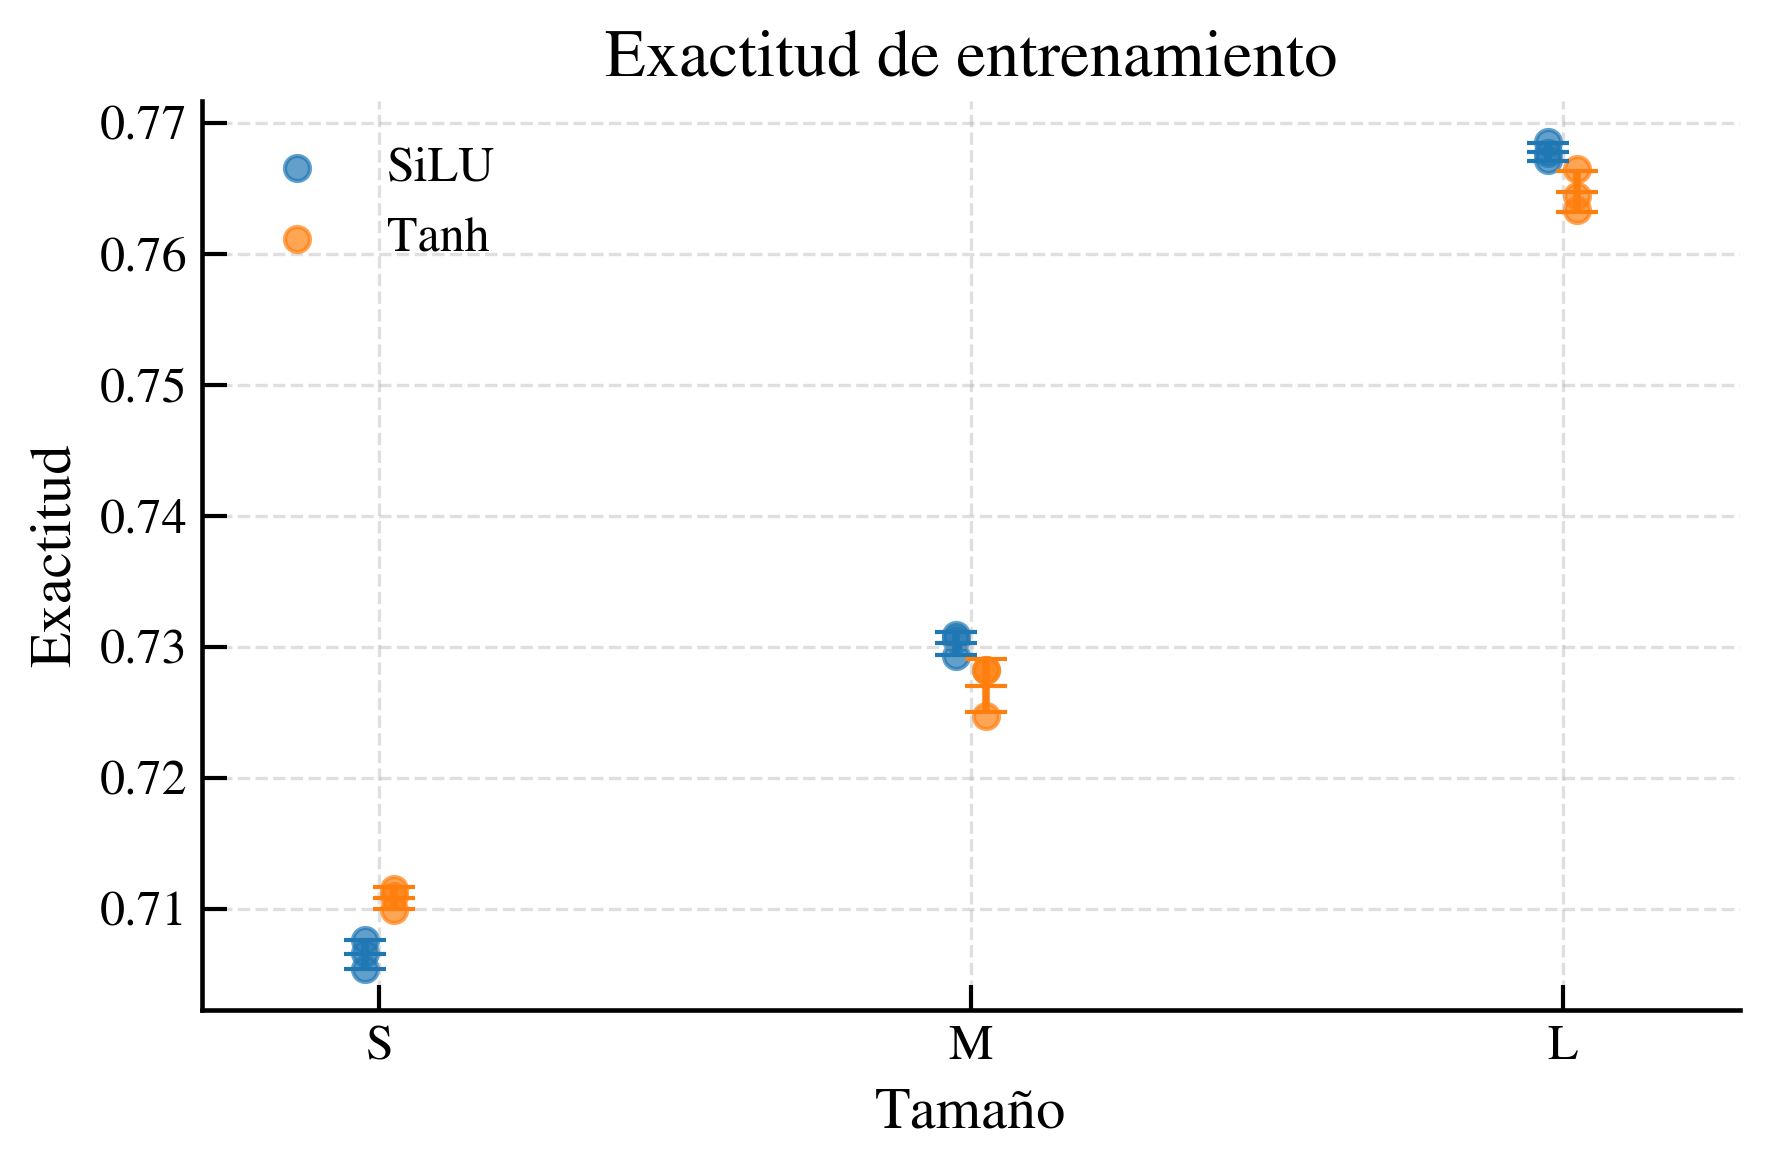

In [101]:
TEXT = {
    'es' : { 
        "xlabel": "Tamaño",
        "ylabel": "Exactitud", 
        'title' : "Exactitud de entrenamiento",
        'size'  : 'Tamaño',
        'seed'  : 'Semilla',
        'name'  : 'Nombre',
        'mean'  : 'Promedio'
    }
}

STYLE = {
    "SwiGLUViT": {
        "label": "SiLU",
        "color": "C0",
        "offset": -0.025,
    },
    "CanonicalViT": {
        "label": "Tanh",
        "color": "C1",
        "offset": 0.025,
    },
}
 
text = TEXT[LANGUAGE]
 
figure, axes = subplots(figsize=(6, 4), dpi=300)
axes.grid(True, linestyle="--", alpha=0.4)
axes.tick_params(direction="in", length=6, width=1) 

dataframes = list[DataFrame]()
for name in ['SwiGLUViT', 'CanonicalViT']:
    text = TEXT[LANGUAGE]
    rows = []

    for size in SIZES:
        for seed in SEEDS:
            dataframe = read_csv(getpath(name, size, seed))
            dataframe = dataframe.loc[dataframe['phase'] == 'train'].tail(WINDOW)

            rows.append({
                text['size']: size,
                text['seed']: seed,
                text['mean']: dataframe['accuracy'].mean(),
                text['name']: name
            })

    dataframes.append(DataFrame(rows))

dataframe = concat(dataframes, ignore_index=True)
indices = {size: index for index, size in enumerate(SIZES)}
 
for name in ['SwiGLUViT', 'CanonicalViT']:
    subset = dataframe[dataframe[text['name']] == name]
    
    for size in SIZES:
        values = subset[subset[text['size']] == size][text['mean']].astype(float)
         
        axes.scatter(
            [indices[size] + STYLE[name]['offset']] * len(values),
            values,
            color=STYLE[name]['color'],
            label=STYLE[name]['label'] if size == SIZES[0] else None,
            alpha=0.7,
        )  

        axes.errorbar(
            x=indices[size] + STYLE[name]['offset'],
            y=values.mean(),
            yerr=values.std(),
            fmt='_',                 
            color=STYLE[name]['color'], 
            elinewidth=1.8,
            capsize=5,
            markersize=10,      
            zorder=5
        )

axes.set_xticks(list(indices.values()), SIZES)
axes.set_xlabel(text['xlabel'])
axes.set_ylabel(text['ylabel']) 
axes.spines["top"].set_visible(False)
axes.spines["right"].set_visible(False)
axes.legend(frameon=False) 
axes.set_title(text['title']) 
axes.set_xlim(min(indices.values()) - 0.3, max(indices.values()) + 0.3)
figure.tight_layout()
show(figure)
close(figure)

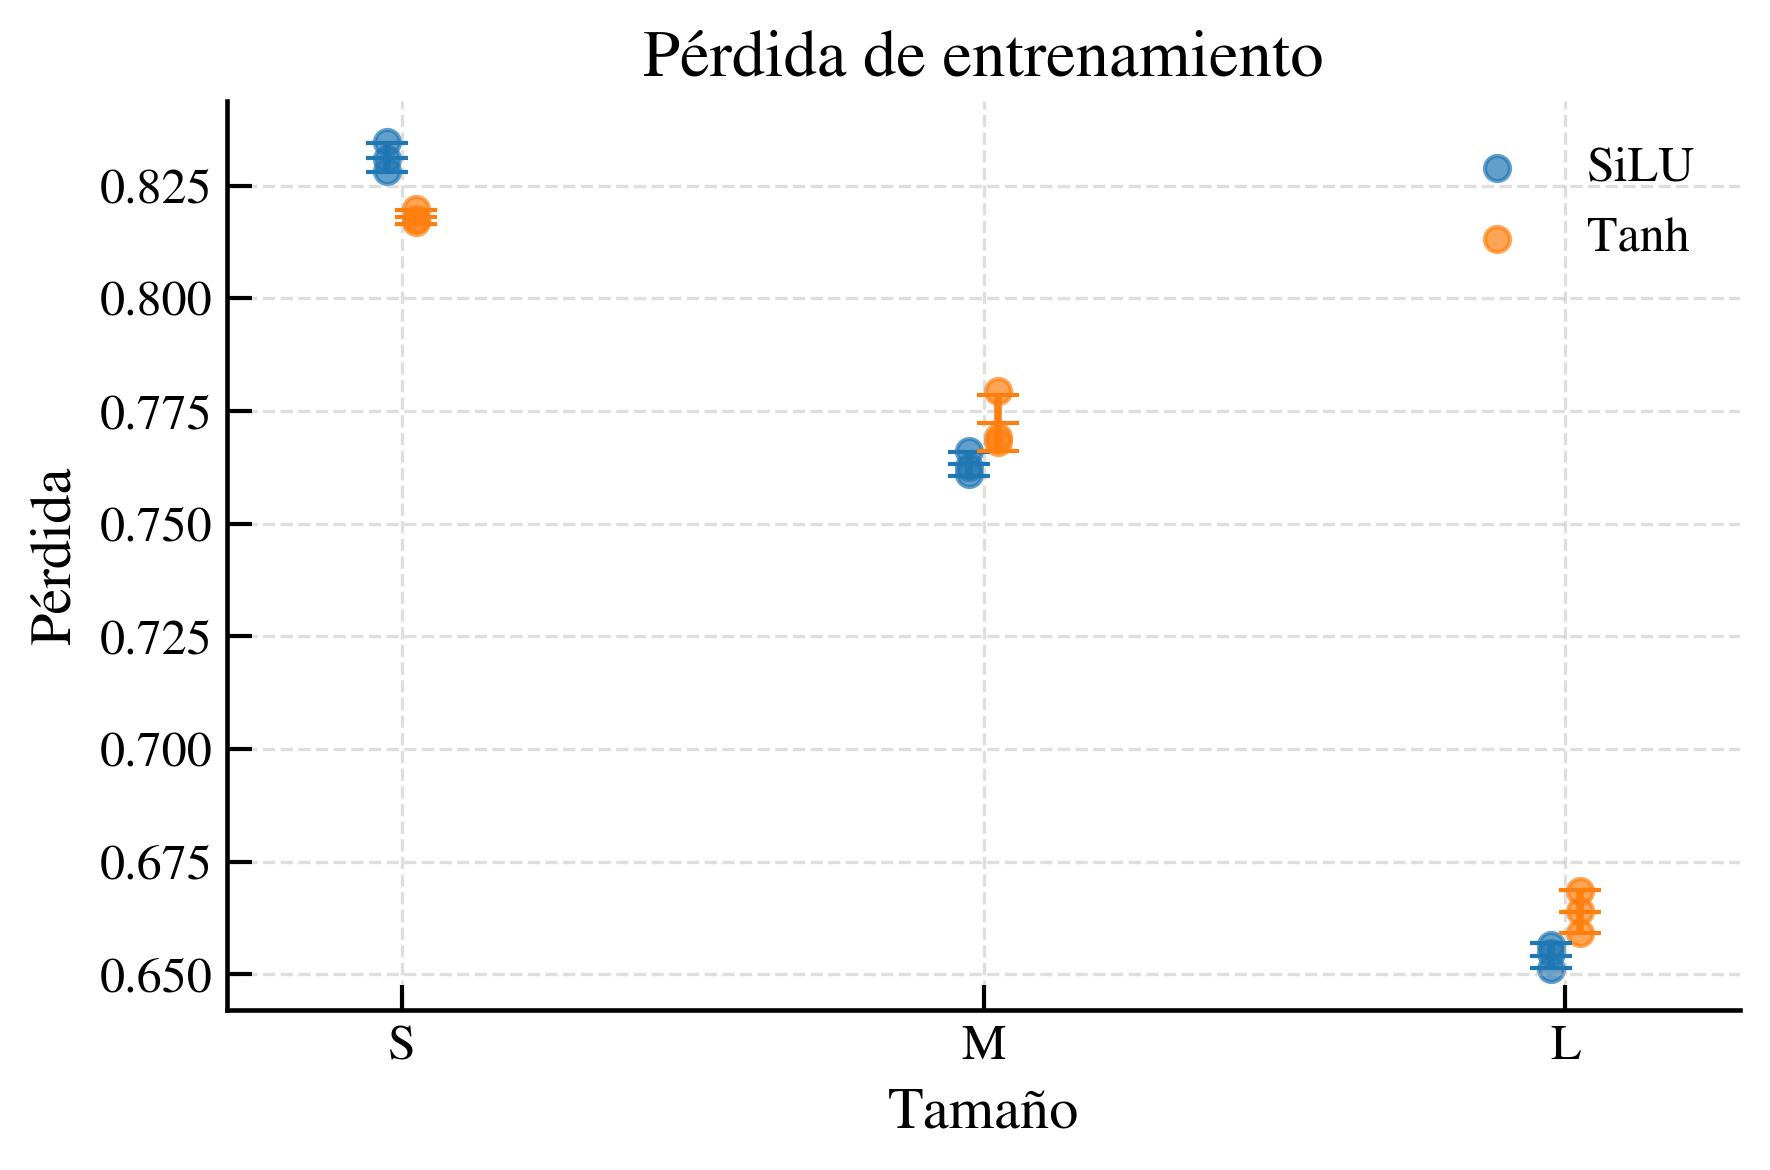

In [102]:
TEXT = {
    'es' : { 
        "xlabel": "Tamaño",
        "ylabel": "Pérdida", 
        'title' : "Pérdida de entrenamiento",
        'size'  : 'Tamaño',
        'seed'  : 'Semilla',
        'name'  : 'Nombre',
        'mean'  : 'Promedio'
    }
}

STYLE = {
    "SwiGLUViT": {
        "label": "SiLU",
        "color": "C0",
        "offset": -0.025,
    },
    "CanonicalViT": {
        "label": "Tanh",
        "color": "C1",
        "offset": 0.025,
    },
}
 
text = TEXT[LANGUAGE]
 
figure, axes = subplots(figsize=(6, 4), dpi=300)
axes.grid(True, linestyle="--", alpha=0.4)
axes.tick_params(direction="in", length=6, width=1) 

dataframes = list[DataFrame]()
for name in ['SwiGLUViT', 'CanonicalViT']:
    text = TEXT[LANGUAGE]
    rows = []

    for size in SIZES:
        for seed in SEEDS:
            dataframe = read_csv(getpath(name, size, seed))
            dataframe = dataframe.loc[dataframe['phase'] == 'train'].tail(WINDOW)

            rows.append({
                text['size']: size,
                text['seed']: seed,
                text['mean']: dataframe['loss'].mean(),
                text['name']: name
            })

    dataframes.append(DataFrame(rows))

dataframe = concat(dataframes, ignore_index=True)
indices = {size: index for index, size in enumerate(SIZES)}
 
for name in ['SwiGLUViT', 'CanonicalViT']:
    subset = dataframe[dataframe[text['name']] == name]
    
    for size in SIZES:
        values = subset[subset[text['size']] == size][text['mean']].astype(float)
         
        axes.scatter(
            [indices[size] + STYLE[name]['offset']] * len(values),
            values,
            color=STYLE[name]['color'],
            label=STYLE[name]['label'] if size == SIZES[0] else None,
            alpha=0.7,
        )  

        axes.errorbar(
            x=indices[size] + STYLE[name]['offset'],
            y=values.mean(),
            yerr=values.std(),
            fmt='_',                 
            color=STYLE[name]['color'], 
            elinewidth=1.8,
            capsize=5,
            markersize=10,      
            zorder=5
        )

axes.set_xticks(list(indices.values()), SIZES)
axes.set_xlabel(text['xlabel'])
axes.set_ylabel(text['ylabel']) 
axes.spines["top"].set_visible(False)
axes.spines["right"].set_visible(False)
axes.legend(frameon=False) 
axes.set_title(text['title']) 
axes.set_xlim(min(indices.values()) - 0.3, max(indices.values()) + 0.3)
figure.tight_layout()
show(figure)
close(figure)

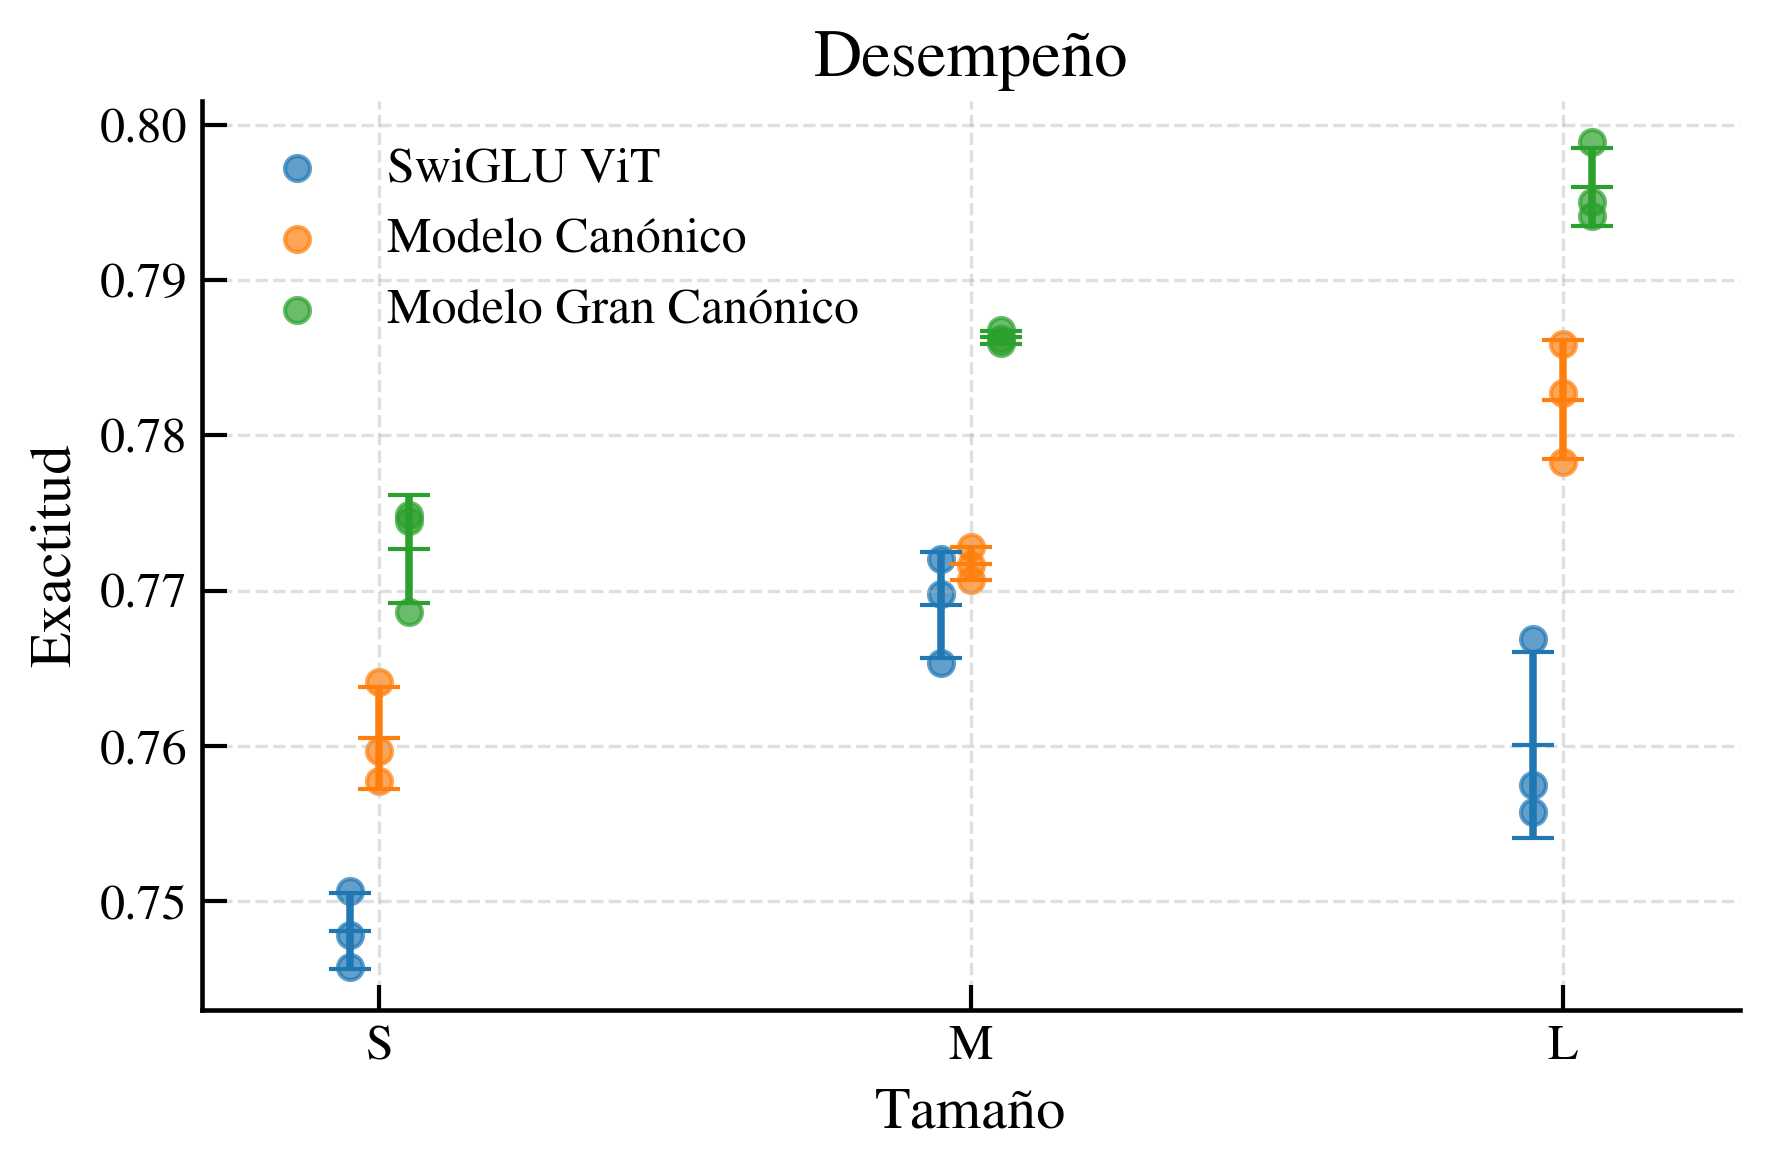

In [103]:
TEXT = {
    'es' : { 
        "xlabel": "Tamaño",
        "ylabel": "Exactitud", 
        'title' : "Desempeño",
        'size'  : 'Tamaño',
        'seed'  : 'Semilla',
        'name'  : 'Nombre',
        'mean'  : 'Promedio'
    }
}

STYLE = {
    "SwiGLUViT": {
        "label": "SwiGLU ViT",
        "color": "C0",
        "offset": -0.05,
    },
    "CanonicalViT": {
        "label": "Modelo Canónico",
        "color": "C1",
        "offset": 0.0,
    },
    "GrandCanonicalViT": {
        "label": "Modelo Gran Canónico",
        "color": "C2",
        "offset": 0.05,
    },
}
 
text = TEXT[LANGUAGE]
 
figure, axes = subplots(figsize=(6, 4), dpi=300)
axes.grid(True, linestyle="--", alpha=0.4)
axes.tick_params(direction="in", length=6, width=1) 

dataframes = list[DataFrame]()
for name in NAMES:
    text = TEXT[LANGUAGE]
    rows = []

    for size in SIZES:
        for seed in SEEDS:
            dataframe = read_csv(getpath(name, size, seed))
            dataframe = dataframe.loc[dataframe['phase'] == 'evaluation'].tail(WINDOW)

            rows.append({
                text['size']: size,
                text['seed']: seed,
                text['mean']: dataframe['accuracy'].mean(),
                text['name']: name
            })

    dataframes.append(DataFrame(rows))

dataframe = concat(dataframes, ignore_index=True)
indices = {size: index for index, size in enumerate(SIZES)}
 
for name in NAMES:
    subset = dataframe[dataframe[text['name']] == name]
    
    for size in SIZES:
        values = subset[subset[text['size']] == size][text['mean']].astype(float)
         
        axes.scatter(
            [indices[size] + STYLE[name]['offset']] * len(values),
            values,
            color=STYLE[name]['color'],
            label=STYLE[name]['label'] if size == SIZES[0] else None,
            alpha=0.7,
        )  

        axes.errorbar(
            x=indices[size] + STYLE[name]['offset'],
            y=values.mean(),
            yerr=values.std(),
            fmt='_',                 
            color=STYLE[name]['color'], 
            elinewidth=1.8,
            capsize=5,
            markersize=10,      
            zorder=5
        )

axes.set_xticks(list(indices.values()), SIZES)
axes.set_xlabel(text['xlabel'])
axes.set_ylabel(text['ylabel']) 
axes.spines["top"].set_visible(False)
axes.spines["right"].set_visible(False)
axes.legend(frameon=False) 
axes.set_title(text['title']) 
axes.set_xlim(min(indices.values()) - 0.3, max(indices.values()) + 0.3)
figure.tight_layout()
show(figure)
close(figure)